# 相关链接

**[Elo Merchant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation)**

In [ ]:
import os
import time
import pickle
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import xgboost as xgb
import lightgbm as lgb

from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from dateutil import relativedelta
from datetime import datetime

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [ ]:
file_path = 'F:/git_repos/Kaggle_code/elo-merchant-category-recommendation/'
# submission_path = 'F:/git_repos/Kaggle_code/elo-merchant-category-recommendation/submission/'

In [ ]:
train_df = pd.read_csv(file_path + '/data/train.csv', parse_dates=['first_active_month'])
test_df = pd.read_csv(file_path + '/data/test.csv', parse_dates=['first_active_month'])
print("Number of rows and columns in train set : ",train_df.shape)
print("Number of rows and columns in test set : ",test_df.shape)

In [4]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


### 目标列探索

通过图形可视化展现目标值的分布情况

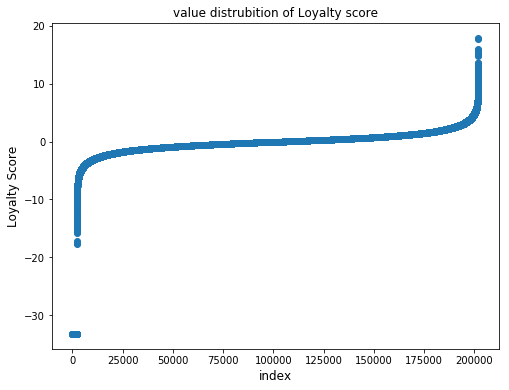

In [5]:
target_col = 'target'

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.title("value distrubition of Loyalty score")
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

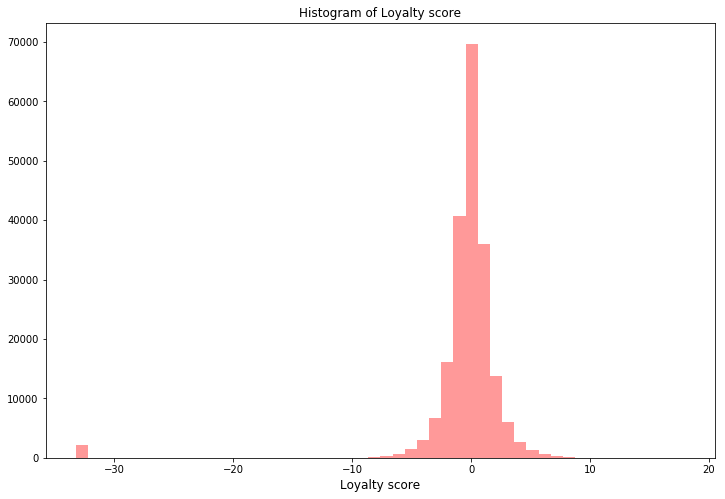

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

In [7]:
train_df['target'].max(), train_df['target'].min()

(17.9650684, -33.21928095)

In [8]:
train_df.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749
5,2016-09-01,C_ID_0894217f2f,4,2,0,0.871585
6,2016-12-01,C_ID_7e63323c00,3,2,1,0.230129
7,2017-09-01,C_ID_dfa21fc124,3,2,1,2.135850
8,2017-08-01,C_ID_fe0fdac8ea,2,1,0,-0.065406
9,2016-08-01,C_ID_bf62c0b49d,2,2,0,0.300062


In [9]:
test_df.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1
5,2017-07-01,C_ID_5814b4f13c,5,1,1
6,2017-10-01,C_ID_a1b3c75277,1,2,0
7,2017-02-01,C_ID_f7cada36d3,3,1,1
8,2017-07-01,C_ID_9d2bc8dfc4,4,3,0
9,2016-03-01,C_ID_6d8dba8475,5,1,1


In [10]:
(train_df[target_col]<-30).sum()

2207

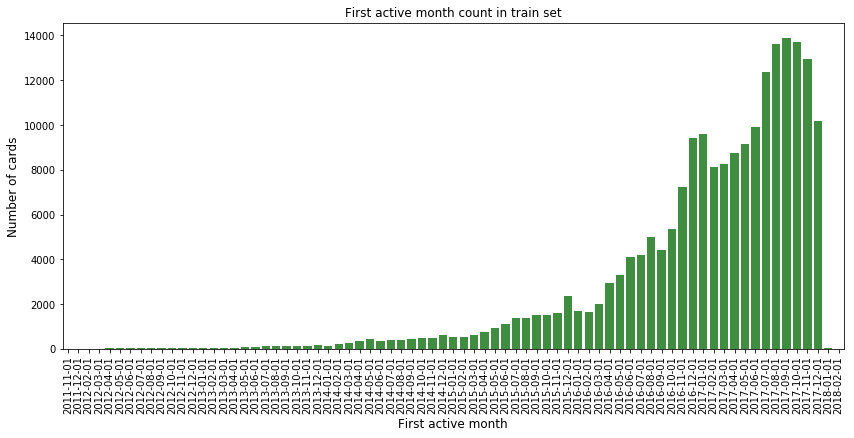

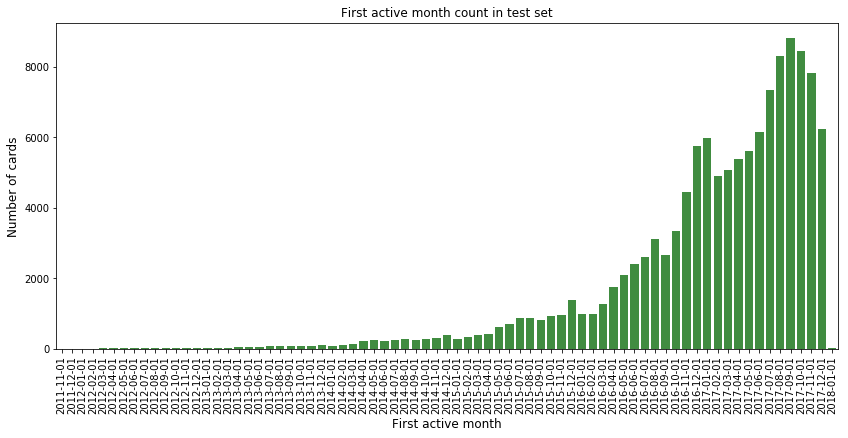

In [11]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

Text(0.5,1,'Feature 3 distribution')

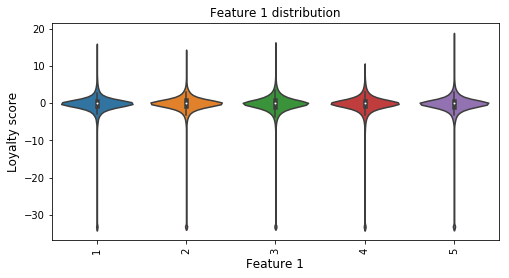

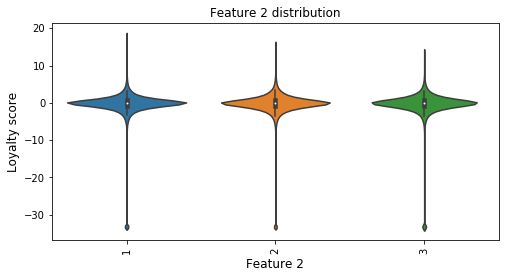

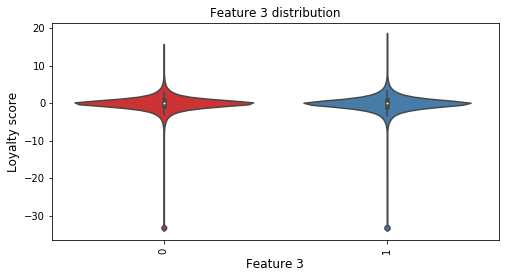

In [12]:
# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
# plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
# plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y=target_col, data=train_df, palette="Set1")
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
# plt.show()

## 历史交易数据分析

In [13]:
hist_df = pd.read_csv(data_path + 'historical_transactions.csv', parse_dates=['purchase_date'])
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [14]:
hist_df['merchant_category_id'].value_counts().sort_index()

-1         2252
 2        46162
 9        13806
 11          38
 14       10225
 16         993
 18           4
 19      143154
 21        2630
 27          25
 31          55
 33       15956
 34       42639
 36        2840
 37           3
 38        1364
 40       88381
 45      225705
 49          35
 52         494
 53        2344
 56        2847
 57        4442
 59           7
 60       23388
 63       74391
 67          12
 68      300512
 69       14447
 71        1788
         ...   
 803        176
 805          3
 806       2890
 808        253
 813      93758
 814        262
 817          6
 818     178481
 819       1125
 823      13158
 827       3613
 829       8897
 834      80910
 836      22105
 839     445622
 840      69019
 842     315091
 843       7233
 847        411
 854       4198
 873       1840
 875          1
 878        124
 879    1430607
 881        101
 882          1
 884     416465
 885       7555
 889        677
 891       6437
Name: merchant_category_

In [15]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [16]:
cnt_srs = train_df.groupby("num_hist_transactions")[target_col].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

trace = scatter_plot(cnt_srs, "orange")
layout = dict(
    title='Loyalty score by Number of historical transactions',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Histtranscnt")

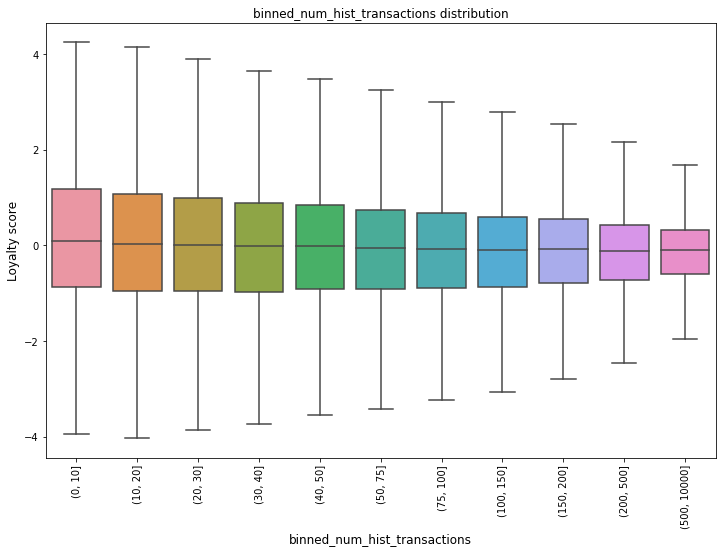

In [17]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.show()

In [18]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

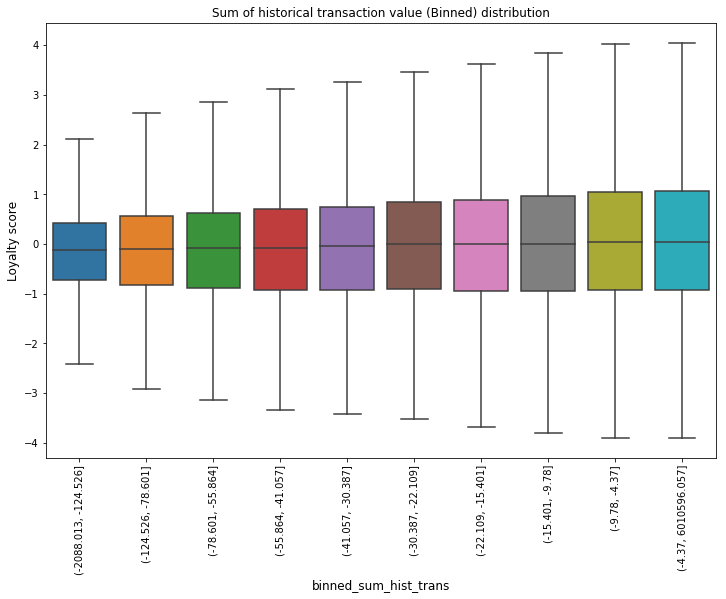

In [19]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of historical transaction value (Binned) distribution")
plt.show()

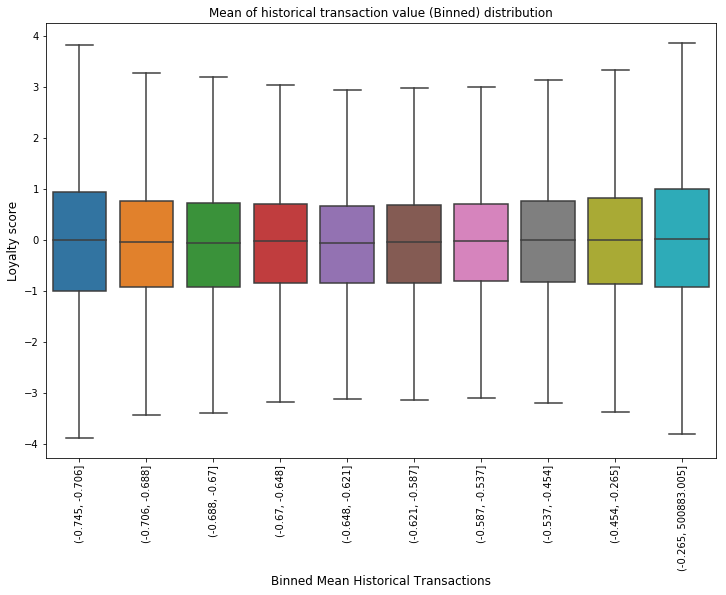

In [20]:
bins = np.percentile(train_df["mean_hist_trans"], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_mean_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned Mean Historical Transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of historical transaction value (Binned) distribution")
plt.show()

In [21]:
new_trans_df = pd.read_csv(data_path + 'new_merchant_transactions.csv', parse_dates=['purchase_date'])
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [22]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_merch_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

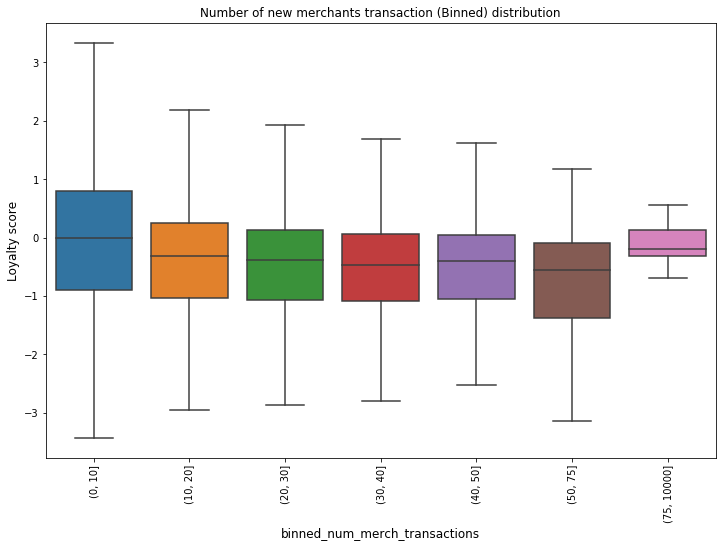

In [23]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_merch_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Number of new merchants transaction (Binned) distribution")
plt.show()

In [24]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

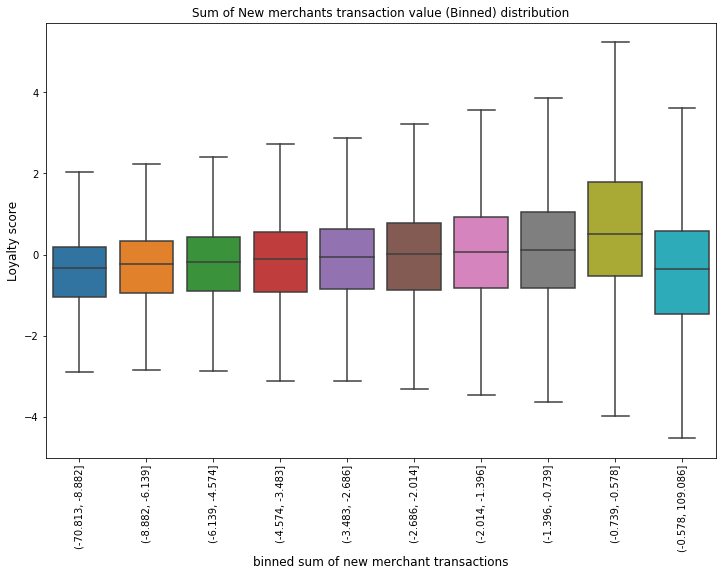

In [25]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (Binned) distribution")
plt.show()

In [26]:
# 增加feature: 持卡人在多少个城市消费过

train_df.drop(columns=['num_hist_distinct_city', 'num_new_distinct_city'], 
              inplace=True, errors='ignore')
test_df.drop(columns=['num_hist_distinct_city', 'num_new_distinct_city'],
             inplace=True, errors='ignore')

gdf = hist_df.groupby("card_id")
gdf = gdf["city_id"].apply(lambda x: len(x.unique())).reset_index()
gdf.columns = ["card_id", "num_hist_distinct_city"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

gdf = new_trans_df.groupby("card_id")
gdf = gdf["city_id"].apply(lambda x: len(x.unique())).reset_index()
gdf.columns = ["card_id", "num_new_distinct_city"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")
print('train_df.shape is ', train_df.shape)

###########################################################################################
# 增加feature: 持卡人在多少个不同商家消费过

train_df.drop(columns=['num_hist_distinct_merchant', 'num_new_distinct_merchant'], 
              inplace=True, errors='ignore')
test_df.drop(columns=['num_hist_distinct_merchant', 'num_new_distinct_merchant'], 
             inplace=True, errors='ignore')
print('train_df.shape is ', train_df.shape)

gdf = hist_df.groupby("card_id")
gdf = gdf["merchant_id"].apply(lambda x: len(x.unique())).reset_index()
gdf.columns = ["card_id", "num_hist_distinct_merchant"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

gdf = new_trans_df.groupby("card_id")
gdf = gdf["city_id"].apply(lambda x: len(x.unique())).reset_index()
gdf.columns = ["card_id", "num_new_distinct_merchant"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

print('train_df.shape is ', train_df.shape)

train_df.shape is  (201917, 25)
train_df.shape is  (201917, 25)
train_df.shape is  (201917, 27)


In [27]:
# 增加feature: 持卡人用卡已经有多少天（截止到2018年5月1日）

#  '2018-04-30 23:59:59'
end_dt = datetime.strptime(str('2018-05-01 00:00:00'), '%Y-%m-%d %H:%M:%S')

def diff_days(dt):
    global end_dt
    return (end_dt - dt).days

train_df["active_days"] = train_df["first_active_month"].apply(diff_days)
test_df["active_days"] = test_df["first_active_month"].apply(diff_days)

print('train_df.shape is ', train_df.shape)
print(train_df[['active_days', 'first_active_month']].head(10))

train_df.shape is  (201917, 28)
   active_days first_active_month
0          334         2017-06-01
1          485         2017-01-01
2          638         2016-08-01
3          242         2017-09-01
4          181         2017-11-01
5          607         2016-09-01
6          516         2016-12-01
7          242         2017-09-01
8          273         2017-08-01
9          638         2016-08-01


In [28]:
# TO Do:
# 1. R 最近一次购买距离当前多少天
# 2. F 最近半年购买次数；总的购买次数
# 3. M 最近半年购买金额；总的购买次数
# 4. 总的购买的频率：购买次数/活跃月份

###########################################################################################
# 增加feature: 持卡人最近一次消费距离当前的天数（截止到2018年5月1日）

# hist_df['purchase_date'] =  pd.to_datetime(hist_df['purchase_date'], format='%Y-%m-%d %H:%M:%S')
# new_trans_df['purchase_date'] =  pd.to_datetime(new_trans_df['purchase_date'], format='%Y-%m-%d %H:%M:%S')

merged_purchase_date_df = pd.concat([new_trans_df[['card_id', 'purchase_date']],
    hist_df[['card_id', 'purchase_date']]])


# print('new_trans_df.shape is ', new_trans_df.shape)
# print('hist_df.shape is ', hist_df.shape)
# print('merged_purchase_date_df.shape is ', merged_purchase_date_df.shape)

# merged_purchase_date_df.drop_duplicates(inplace=True)

# print('after drop duplicates merged_purchase_date_df.shape is ', 
#       merged_purchase_date_df.shape)

train_df.drop(columns=['max_purchase_date', 'recency'], inplace=True, errors='ignore')
test_df.drop(columns=['max_purchase_date', 'recency'], inplace=True, errors='ignore')

gdf = merged_purchase_date_df.groupby("card_id")
gdf = gdf["purchase_date"].apply(lambda x: x.max()).reset_index()
gdf.columns = ["card_id", "max_purchase_date"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")
train_df['recency'] = train_df['max_purchase_date'].apply(diff_days)
test_df['recency'] = test_df['max_purchase_date'].apply(diff_days)

print('train_df.shape is ', train_df.shape)

train_df.shape is  (201917, 30)


(31075392, 3)
14
1161151
29914241
31075392
31075392
median is  -0.68752302
min max is -0.7469078 6010603.9717525


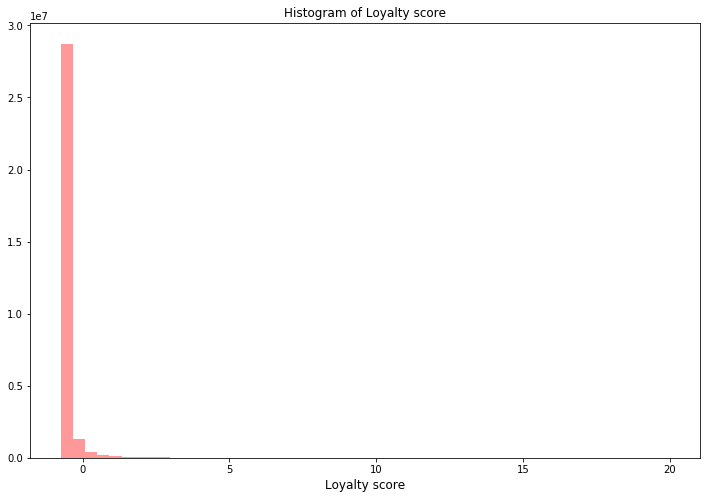

In [63]:
###########################################################################################
# 增加feature: 持卡人最近三个月、最近半年、最近一年的消费金额（截止到2018年5月1日）

# merged_purchase_date_df = pd.concat([new_trans_df[['card_id', 'purchase_amount', 'purchase_date']],
#     hist_df[['card_id', 'purchase_amount', 'purchase_date']]])

# print('merged_purchase_date_df.shape is ', merged_purchase_date_df.shape)


# fig,ax=plt.subplots()

# ax.hist(merged_purchase_date_df['purchase_amount'].values, bins=50, 
#         histtype="stepfilled",alpha=0.6,label="robbery")

# print(merged_purchase_date_df['purchase_amount'].min(), merged_purchase_date_df['purchase_amount'].max())

print(merged_purchase_date_df.shape)
print((merged_purchase_date_df['purchase_amount']>=10**5).sum())
print((merged_purchase_date_df['purchase_amount']>=0.0).sum())
print((merged_purchase_date_df['purchase_amount']<0.0).sum())
print((merged_purchase_date_df['purchase_amount']>-1.0).sum())
print((merged_purchase_date_df['purchase_amount']>-0.988).sum())
print('median is ', merged_purchase_date_df['purchase_amount'].median())
print('min max is', merged_purchase_date_df['purchase_amount'].min(),
     merged_purchase_date_df['purchase_amount'].max())


plt.figure(figsize=(12,8))
# sns.distplot(merged_purchase_date_df[(merged_purchase_date_df['purchase_amount']>=0.0) & 
#              (merged_purchase_date_df['purchase_amount']<=20.0)]['purchase_amount'].values, 
#              bins=50, kde=False, color="red")
sns.distplot(merged_purchase_date_df[merged_purchase_date_df['purchase_amount']<=20.0]['purchase_amount'].values, 
             bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()


# fig,ax=plt.subplots()
# ax.hist(merged_purchase_date_df[merged_purchase_date_df['purchase_amount']<=10]['purchase_amount'].values, 
#         bins=50, histtype="stepfilled",alpha=0.6,label="robbery")


# print('new_trans_df.shape is ', new_trans_df.shape)
# print('hist_df.shape is ', hist_df.shape)
# print('merged_purchase_date_df.shape is ', merged_purchase_date_df.shape)

# merged_purchase_date_df.drop_duplicates(inplace=True)

# print('after drop duplicates merged_purchase_date_df.shape is ', 
#       merged_purchase_date_df.shape)

# train_df.drop(columns=['max_purchase_date', 'recency'], inplace=True, errors='ignore')
# test_df.drop(columns=['max_purchase_date', 'recency'], inplace=True, errors='ignore')

# gdf = merged_purchase_date_df.groupby("card_id")
# gdf = gdf["purchase_date"].apply(lambda x: x.max()).reset_index()
# gdf.columns = ["card_id", "max_purchase_date"]
# train_df = pd.merge(train_df, gdf, on="card_id", how="left")
# test_df = pd.merge(test_df, gdf, on="card_id", how="left")
# train_df['recency'] = train_df['max_purchase_date'].apply(diff_days)
# test_df['recency'] = test_df['max_purchase_date'].apply(diff_days)

# print('train_df.shape is ', train_df.shape)

In [ ]:
###########################################################################################
# 增加feature: 持卡人最近三个月、最近半年、最近一年的消费次数（截止到2018年5月1日）

merged_purchase_date_df = pd.concat([new_trans_df[['card_id', 'purchase_date']],
    hist_df[['card_id', 'purchase_date']]])

# print('new_trans_df.shape is ', new_trans_df.shape)
# print('hist_df.shape is ', hist_df.shape)
# print('merged_purchase_date_df.shape is ', merged_purchase_date_df.shape)

# merged_purchase_date_df.drop_duplicates(inplace=True)

# print('after drop duplicates merged_purchase_date_df.shape is ', 
#       merged_purchase_date_df.shape)

train_df.drop(columns=['max_purchase_date', 'recency'], inplace=True, errors='ignore')
test_df.drop(columns=['max_purchase_date', 'recency'], inplace=True, errors='ignore')

gdf = merged_purchase_date_df.groupby("card_id")
gdf = gdf["purchase_date"].apply(lambda x: x.max()).reset_index()
gdf.columns = ["card_id", "max_purchase_date"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")
train_df['recency'] = train_df['max_purchase_date'].apply(diff_days)
test_df['recency'] = test_df['max_purchase_date'].apply(diff_days)

print('train_df.shape is ', train_df.shape)

结果证明上面的特征中，R的作用很大

In [29]:
# new_trans_df.month_lag.value_counts().sort_index()
# hist_df.month_lag.value_counts()
###########################################################################################
# 增加feature: 处理month_lag特征

features_to_contruct = ['sum_month_lag', 'mean_month_lag', 
                        'std_month_lag', 'min_month_lag', 'max_month_lag']

train_df.drop(columns=features_to_contruct, inplace=True, errors='ignore')
test_df.drop(columns=features_to_contruct, inplace=True, errors='ignore')

gdf = new_trans_df.groupby("card_id")
gdf = gdf["month_lag"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ['card_id', 'sum_month_lag', 'mean_month_lag', 'std_month_lag', 'min_month_lag', 'max_month_lag']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

In [30]:
# new_trans_df.installments.value_counts().sort_index()
# hist_df.installments.value_counts().sort_index()
###########################################################################################
# 增加feature: 处理installments特征， todo: -1和999都设置为NA

features_to_contruct = ['sum_installments', 'mean_installments', 
                        'std_installments', 'min_installments', 'max_installments']

train_df.drop(columns=features_to_contruct, inplace=True, errors='ignore')
test_df.drop(columns=features_to_contruct, inplace=True, errors='ignore')

gdf = new_trans_df.groupby("card_id")
gdf = gdf["installments"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ['card_id', 'sum_installments', 'mean_installments', 'std_installments', 'min_installments', 'max_installments']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

In [67]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month", 
               "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", 
               "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans"]

# features added by tsg
cols_tsg = ['active_days', 
            'recency',
            'num_hist_distinct_city', 'num_new_distinct_city',
            'num_hist_distinct_merchant', 'num_new_distinct_merchant',
            'sum_month_lag', 'mean_month_lag', 
            'std_month_lag', 'min_month_lag', 'max_month_lag',
            'sum_installments', 'mean_installments',
            'std_installments', 'min_installments', 'max_installments',
           ]

cols_to_use += cols_tsg

# upper_threshold = mean + 3*std
# lower_threshold = mean - 3*std

# train_df_filtered = train_df[(train_df[target_col]<upper_threshold) & (train_df[target_col]>lower_threshold)]
# print('train_df_filtered.shape is', train_df_filtered.shape)
# print('train_df.shape is', train_df.shape)

# train_X = train_df_filtered[cols_to_use]
# train_y = train_df_filtered[target_col].values

train_X = train_df[cols_to_use]
train_y = train_df[target_col].values
test_X = test_df[cols_to_use]

## 本地分5份 CV跑

def run_lgb(dev_X, dev_y, val_X, val_y, test_X):
    print('in run_lgb')
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 100,
        "min_child_weight" : 0.5,
        "learning_rate" : 0.02,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(dev_X, label=dev_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    best_rmse = model.best_score['valid_0']['rmse']
    best_iter_num = model.best_iteration
    print('model.best_score: {} model.best_iteration: {} '.format(best_rmse, best_iter_num))
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, best_rmse, best_iter_num, model

def get_CV_outcome(train_X, train_y, test_X, CV_num=5):
    pred_test = 0
    best_rmse = 0
    best_iter_num = 0
    kf = model_selection.KFold(n_splits=CV_num, random_state=2018, shuffle=True)
    for dev_index, val_index in kf.split(train_df):
    # for dev_index, val_index in kf.split(train_df_filtered):
        dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        pred_test_tmp, rmse, iter_num, model = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
        pred_test += pred_test_tmp
        best_rmse += rmse
        best_iter_num += iter_num
    pred_test /= float(CV_num)
    best_rmse /= float(CV_num)
    best_iter_num /= float(CV_num)        
    print('CV running finished!')
    print('final is best_rmse: {} best_iter_num: {}'.format(best_rmse, best_iter_num))
    return pred_test

pred_test_y_CV = get_CV_outcome(train_X, train_y, test_X)

sub_df = pd.DataFrame({"card_id": test_df["card_id"].values})
sub_df["target"] = pred_test_y_CV
sub_df.to_csv(submission_path + 'submission_lgb_CV.csv', index=False)

########################################################################################

in run_lgb
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.73601
[200]	valid_0's rmse: 3.72537
[300]	valid_0's rmse: 3.72176
[400]	valid_0's rmse: 3.72265
Early stopping, best iteration is:
[305]	valid_0's rmse: 3.72153
model.best_score: 3.7215262455634472 model.best_iteration: 305 
in run_lgb
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.68493
[200]	valid_0's rmse: 3.67096
[300]	valid_0's rmse: 3.66987
[400]	valid_0's rmse: 3.67006
Early stopping, best iteration is:
[324]	valid_0's rmse: 3.66925
model.best_score: 3.669246849926215 model.best_iteration: 324 
in run_lgb
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.71843
[200]	valid_0's rmse: 3.7013
[300]	valid_0's rmse: 3.69657
[400]	valid_0's rmse: 3.69525
Early stopping, best iteration is:
[376]	valid_0's rmse: 3.69499
model.best_score: 3.694987851020765 model.best_iteration: 376 
in run_lgb
Training until validati

In [33]:
# 利用完整的训练样例去跑模型
print('full running starts')
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 100,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : 1
}    
lgtrain = lgb.Dataset(train_X, label=train_y)
model = lgb.train(params, lgtrain, 1000, verbose_eval=200)
pred_test_y = model.predict(test_X)

print('full running ends')

sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = pred_test_y
sub_df.to_csv(submission_path + 'submission_lgb_full.csv', index=False)

full running starts
full running ends


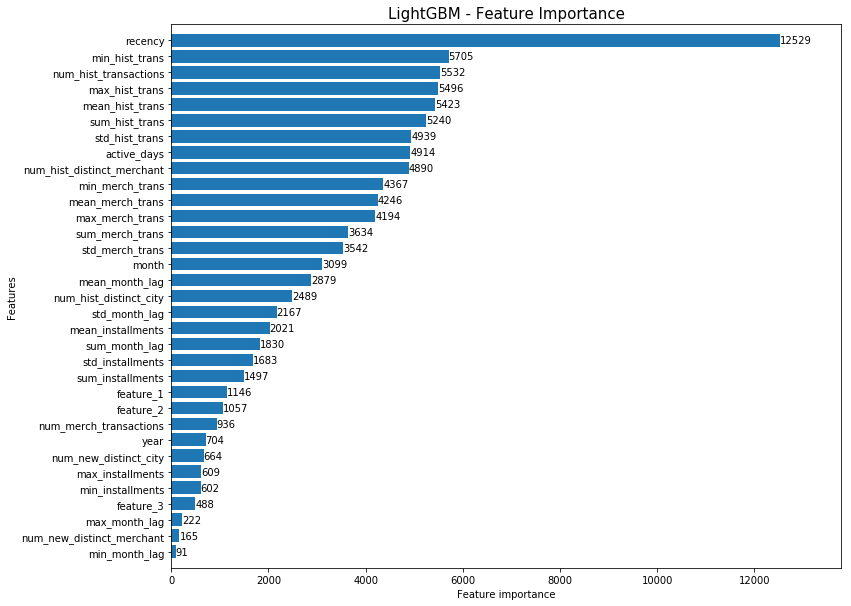

In [65]:
## 展示lightGBM的特征重要性排序
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

** 去除outlier **

In [ ]:
mean = train_df[target_col].mean()
std = train_df[target_col].std()

upper_threshold = mean + 2*std
lower_threshold = mean - 2*std

train_df_filtered = train_df[(train_df[target_col]<upper_threshold) & (train_df[target_col]>lower_threshold)]
print('train_df_filtered.shape is', train_df_filtered.shape)
print('train_df.shape is', train_df.shape)

In [ ]:
# test_df.shape, train_df.shape
# and_set = set(test_df['card_id']) & set(train_df['card_id'])

origin_len = len(set(merged_purchase_date_df['card_id']))
and_set = set(merged_purchase_date_df['card_id']) | set(train_df['card_id'])
origin_len, len(and_set)

In [ ]:
## 疑问：
## 在两份历史记录合并后 有同样的数据（同一个card_id 同一个购物时间）

## To-Do features List:
## authorized_flag